In [1]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.medical_imaging import get_chexpert
from source.utils.metrics import auroc, aod, eod, spd, get_prs, get_tprs, get_fprs

os.makedirs(PLOTS_PATH, exist_ok=True)

/system/apps/userenv/kschweig/quam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

models = ["resnet18", "resnet34", "resnet50"]

pas = ["old", "woman", "white"]
pa = 0 # 0, 1, 2

In [3]:
full_ds, _, _ = get_chexpert(load_to_ram=False)

run_path = os.path.join(RESULTS_PATH, f"chexpert_{models[0]}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds))

y_fair_t = full_ds.targets[fair_inds]
a_fair_t = full_ds.protected_attributes[pa, fair_inds]
y_val_t = full_ds.targets[val_inds]
a_val_t = full_ds.protected_attributes[pa, val_inds]

# switch 0 / 1 in protected attribute
pas = ["young", "man", "non-white"]
a_fair_t = 1 - a_fair_t
a_val_t = 1 - a_val_t

p_a_fair = a_fair_t.float().mean().item() * 100

# patients general 65401
# patients with race 58010
24638 24638


In [4]:
# load probits
fair_probits, val_probits = list(), list()
for mseed in method_seeds:
    for model in models:
        path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{mseed}_dseed{dseed}")

        # don't do fairness ensemble on medical imaging - use this split as test dataset
        fair_probits.append(torch.load(os.path.join(path, f"fair_probits.pt")))
        val_probits.append(torch.load(os.path.join(path, f"val_probits.pt")))

# make array and reshape
fair_probits = torch.stack(fair_probits).reshape(len(method_seeds), -1, len(fair_inds), 2)
val_probits = torch.stack(val_probits).reshape(len(method_seeds), -1, len(val_inds), 2)
# shuffle second dimension
torch.manual_seed(42)
fair_probits = fair_probits[:, torch.randperm(fair_probits.size(1))]
val_probits = val_probits[:, torch.randperm(val_probits.size(1))]

In [5]:
# calculate accuracies and fairness measures
fair_aurocs, val_aurocs = list(), list()
fair_spds, val_spds = list(), list()
fair_eods, val_eods = list(), list()
fair_aods, val_aods = list(), list()

for m in range(len(method_seeds)):
    fair_aurocs.append([auroc(p[:, 1], y_fair_t) for p in fair_probits[m]])
    val_aurocs.append([auroc(p[:, 1], y_val_t) for p in val_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])

    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

In [6]:
fair_m_aurocs = list()
fair_m_spds = list()
fair_m_eods = list()
fair_m_aods = list()

for m in range(len(method_seeds)):
    fair_m_aurocs.append(auroc(torch.mean(fair_probits[m], dim=0)[:, 1], y_fair_t))

    fair_m_spds.append(spd(torch.mean(fair_probits[m], dim=0).argmax(dim=1), a_fair_t))
    
    fair_m_eods.append(eod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

    fair_m_aods.append(aod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

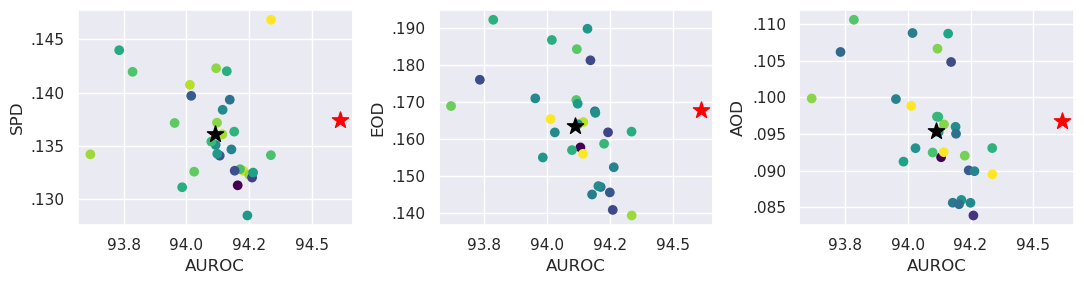

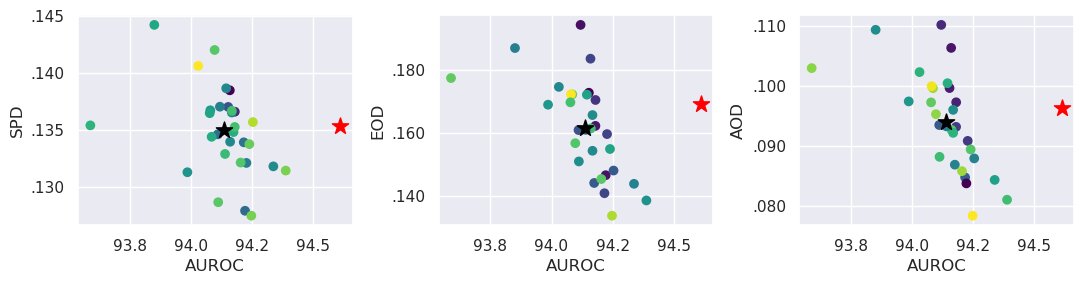

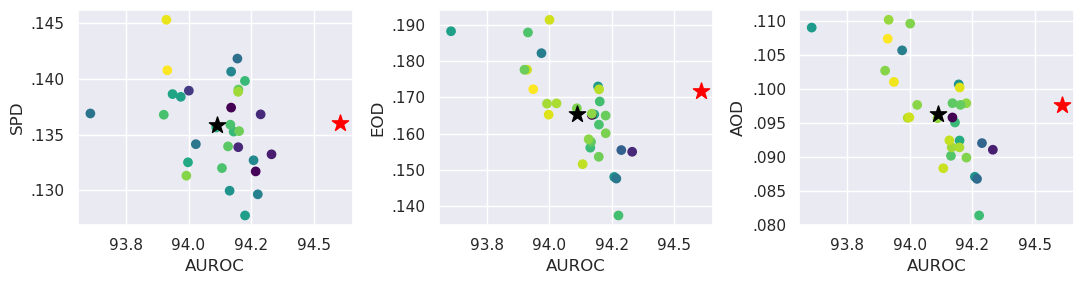

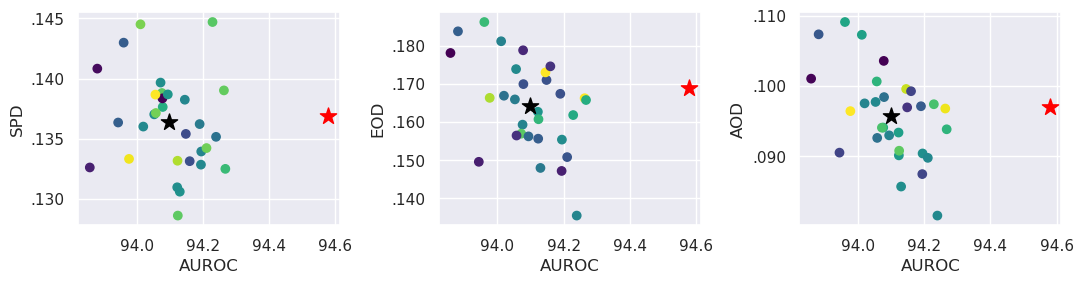

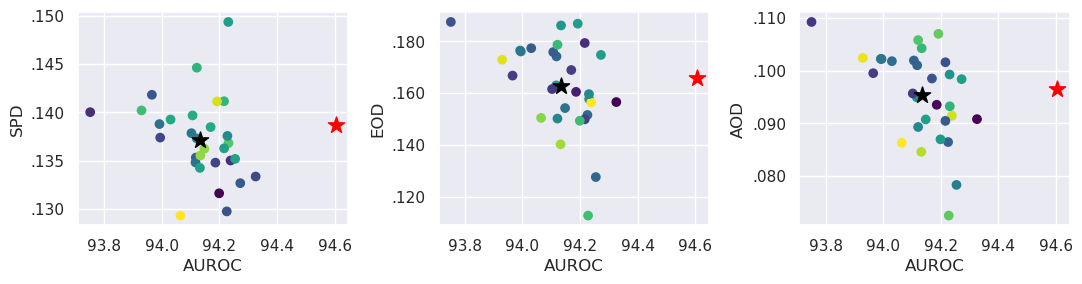

In [7]:
for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(1, 3, figsize=(11, 3))
    axs[0].scatter(fair_aurocs[m], fair_spds[m], c=val_spds[m], cmap="viridis_r")
    axs[0].scatter(np.mean(fair_aurocs[m]), np.mean(fair_spds[m]), marker="*", c="black", s=150)
    axs[0].scatter(fair_m_aurocs[m], fair_m_spds[m], marker="*", c="red", s=150)
    axs[0].set_ylabel("SPD")
    axs[1].scatter(fair_aurocs[m], fair_eods[m], c=val_eods[m], cmap="viridis_r")
    axs[1].scatter(np.mean(fair_aurocs[m]), np.mean(fair_eods[m]), marker="*", c="black", s=150)
    axs[1].scatter(fair_m_aurocs[m], fair_m_eods[m], marker="*", c="red", s=150)
    axs[1].set_ylabel("EOD")
    axs[2].scatter(fair_aurocs[m], fair_aods[m], c=val_aods[m], cmap="viridis_r")
    axs[2].scatter(np.mean(fair_aurocs[m]), np.mean(fair_aods[m]), marker="*", c="black", s=150)
    axs[2].scatter(fair_m_aurocs[m], fair_m_aods[m], marker="*", c="red", s=150)
    axs[2].set_ylabel("AOD")

    for ax in axs.flatten():
        ax.set_xlabel("AUROC")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    f.tight_layout()
    plt.show()

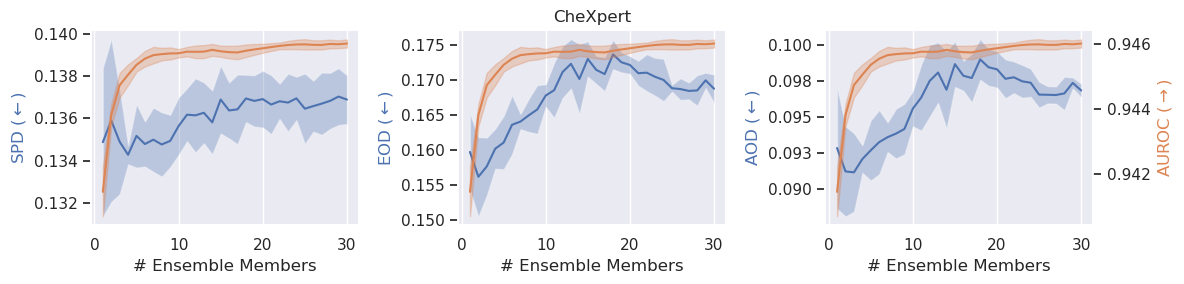

In [10]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

fair_fm_aurocs, fair_fm_spds, fair_fm_eods, fair_fm_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):

    fair_fm_aurocs_, fair_fm_spds_, fair_fm_eods_, fair_fm_aods_ = list(), list(), list(), list()

    for em in ensemble_members:
        preds = torch.mean(fair_probits[m][:em], dim=0)
        fair_fm_aurocs_.append(auroc(preds[:, 1], y_fair_t))
        preds = preds.argmax(dim=1)
        fair_fm_spds_.append(spd(preds, a_fair_t))
        fair_fm_eods_.append(eod(preds, y_fair_t, a_fair_t))
        fair_fm_aods_.append(aod(preds, y_fair_t, a_fair_t))

    fair_fm_aurocs.append(fair_fm_aurocs_)
    fair_fm_spds.append(fair_fm_spds_)
    fair_fm_eods.append(fair_fm_eods_)
    fair_fm_aods.append(fair_fm_aods_)

fair_fm_aurocs = np.asarray(fair_fm_aurocs)
fair_fm_spds = np.asarray(fair_fm_spds)
fair_fm_eods = np.asarray(fair_fm_eods)
fair_fm_aods = np.asarray(fair_fm_aods)

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(fair_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                       np.mean(fair_fm_spds, axis=0) - np.std(fair_fm_spds, axis=0), 
                       np.mean(fair_fm_spds, axis=0) + np.std(fair_fm_spds, axis=0), alpha=0.3)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("SPD ($\\leftarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(fair_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members, 
                       np.mean(fair_fm_eods, axis=0) - np.std(fair_fm_eods, axis=0), 
                       np.mean(fair_fm_eods, axis=0) + np.std(fair_fm_eods, axis=0), alpha=0.3)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("EOD ($\\leftarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(fair_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members, 
                       np.mean(fair_fm_aods, axis=0) - np.std(fair_fm_aods, axis=0), 
                       np.mean(fair_fm_aods, axis=0) + np.std(fair_fm_aods, axis=0), alpha=0.3)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("AOD ($\\leftarrow$)", color="C0")

axs[1].set_title("CheXpert")

for ax in acc_axs:
    ax.plot(ensemble_members, np.mean(fair_fm_aurocs, axis=0), "-", c="C1")
    ax.fill_between(ensemble_members, 
                    np.mean(fair_fm_aurocs, axis=0) - np.std(fair_fm_aurocs, axis=0), 
                    np.mean(fair_fm_aurocs, axis=0) + np.std(fair_fm_aurocs, axis=0), alpha=0.3, color="C1")

for ax in axs.flatten():
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("AUROC ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_hetens.pdf"))
plt.show()

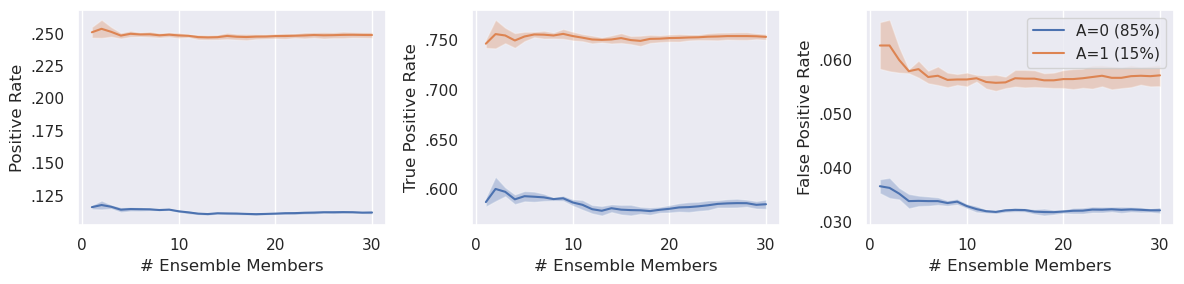

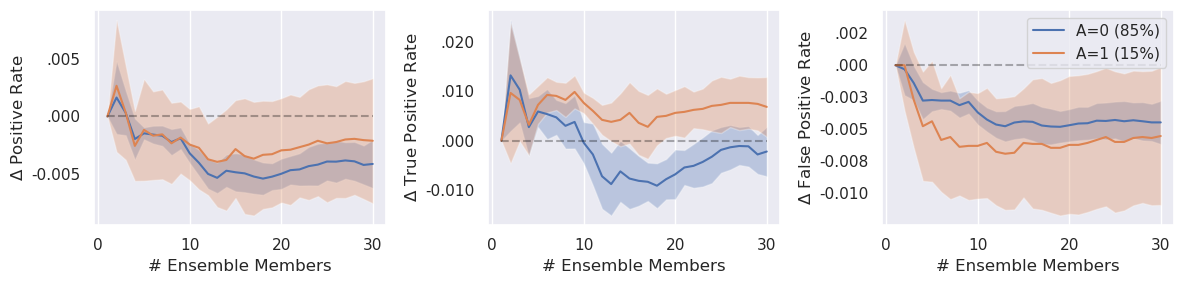

In [9]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

for delta in [False, True]:

    fair_fm_prs_1, fair_fm_prs_0 = list(), list()
    fair_fm_tprs_1, fair_fm_tprs_0 = list(), list()
    fair_fm_fprs_1, fair_fm_fprs_0 = list(), list()
    

    for m in range(len(method_seeds)):

        fair_fm_prs_1_, fair_fm_prs_0_ = list(), list()
        fair_fm_tprs_1_, fair_fm_tprs_0_ = list(), list()
        fair_fm_fprs_1_, fair_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(fair_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_fair_t)
            tpr1, tpr0 = get_tprs(preds, y_fair_t, a_fair_t)
            fpr1, fpr0 = get_fprs(preds, y_fair_t, a_fair_t)
            fair_fm_prs_1_.append(pr1)
            fair_fm_prs_0_.append(pr0)
            fair_fm_tprs_1_.append(tpr1)
            fair_fm_tprs_0_.append(tpr0)
            fair_fm_fprs_1_.append(fpr1)
            fair_fm_fprs_0_.append(fpr0)
            
        if delta:
            fair_fm_prs_1.append([t - fair_fm_prs_1_[0] for t in fair_fm_prs_1_])
            fair_fm_prs_0.append([t - fair_fm_prs_0_[0] for t in fair_fm_prs_0_])
            fair_fm_tprs_1.append([t - fair_fm_tprs_1_[0] for t in fair_fm_tprs_1_])
            fair_fm_tprs_0.append([t - fair_fm_tprs_0_[0] for t in fair_fm_tprs_0_])
            fair_fm_fprs_1.append([t - fair_fm_fprs_1_[0] for t in fair_fm_fprs_1_])
            fair_fm_fprs_0.append([t - fair_fm_fprs_0_[0] for t in fair_fm_fprs_0_])

        else:
            fair_fm_prs_1.append(fair_fm_prs_1_)
            fair_fm_prs_0.append(fair_fm_prs_0_)
            fair_fm_tprs_1.append(fair_fm_tprs_1_)
            fair_fm_tprs_0.append(fair_fm_tprs_0_)
            fair_fm_fprs_1.append(fair_fm_fprs_1_)
            fair_fm_fprs_0.append(fair_fm_fprs_0_)

    fair_fm_prs_1 = np.asarray(fair_fm_prs_1)
    fair_fm_prs_0 = np.asarray(fair_fm_prs_0)
    fair_fm_tprs_1 = np.asarray(fair_fm_tprs_1)
    fair_fm_tprs_0 = np.asarray(fair_fm_tprs_0)
    fair_fm_fprs_1 = np.asarray(fair_fm_fprs_1)
    fair_fm_fprs_0 = np.asarray(fair_fm_fprs_0)

    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([fair_fm_prs_0, fair_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), alpha=0.3)
    axs[0].set_ylabel("$\Delta$ Positive Rate" if delta else "Positive Rate")
    for t, test_pr in enumerate([fair_fm_tprs_0, fair_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_pr, axis=0), "-", 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[1].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), alpha=0.3)
    axs[1].set_ylabel("$\Delta$ True Positive Rate" if delta else "True Positive Rate")
    for t, test_pr in enumerate([fair_fm_fprs_0, fair_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_pr, axis=0), "-", 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[2].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), alpha=0.3)
    axs[2].set_ylabel("$\Delta$ False Positive Rate" if delta else "False Positive Rate")
    axs[2].legend(loc="upper right")

    for ax in axs:
        ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_hetens_delta_rates.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_hetens_rates.pdf"))
    plt.show()